In [ ]:
%pip install -U langchain-community
%pip install -U langgraph
%pip install -U langgraph langchain-community
%pip install python-dotenv

In [13]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated, List
import operator

from openai import OpenAI
from langchain_openai import ChatOpenAI

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_tavily import TavilySearch

In [3]:
import os
from dotenv import load_dotenv

load_dotenv()

os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY') 
os.environ['TAVILY_API_KEY'] = os.getenv('TAVILY_API_KEY')

In [4]:
tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


C:\Users\rondi\AppData\Local\Temp\ipykernel_10568\1287549681.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tool = TavilySearchResults(max_results=4)


In [5]:
class AgentState(TypedDict): 
    messages: Annotated[list[AnyMessage], operator.add]


In [6]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_gemini)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_gemini(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:
                print("\n ....bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [7]:
prompt = """Você é um assistente de pesquisa inteligente. Use o mecanismo de busca para procurar informações. \
Você tem permissão para fazer múltiplas chamadas (seja em conjunto ou em sequência). \
Procure informações apenas quando tiver certeza do que você quer. \
Se precisar pesquisar alguma informação antes de fazer uma pergunta de acompanhamento, você tem permissão para fazer isso!
"""

model = ChatOpenAI(model="gpt-5.1-2025-11-13", temperature=0)

abot = Agent(model, [tool], system=prompt)

In [8]:
mermaid_code = abot.graph.get_graph().draw_mermaid()
print(mermaid_code)

---
config:
  flowchart:
    curve: linear
---
graph TD;
	__start__([<p>__start__</p>]):::first
	llm(llm)
	action(action)
	__end__([<p>__end__</p>]):::last
	__start__ --> llm;
	action --> llm;
	llm -. &nbsp;False&nbsp; .-> __end__;
	llm -. &nbsp;True&nbsp; .-> action;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



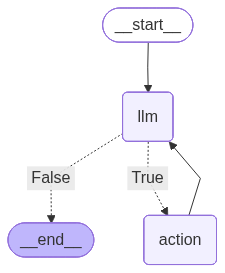

In [9]:
from IPython.display import Image, display

try:
    
    image_data = abot.graph.get_graph().draw_mermaid_png()
    display(Image(data=image_data))

except Exception as e:
    print(f"Erro ao tentar gerar PNG do Mermaid: {e}")
    print("\nCertifique-se de que a sua versão do LangGraph possui o método `.draw_mermaid_png()`.")
    print("Como alternativa, use `.draw_mermaid()` para obter a string e visualizar externamente.")

In [ ]:
%pip install -U langchain-tavily

In [11]:
class Agent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_gemini)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_gemini(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t_call in tool_calls:
            print(f"Calling tool: {t_call['name']} with args: {t_call['args']}")
            if t_call['name'] not in self.tools:
                print("\n ....bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t_call['name']].invoke(t_call['args'])
            results.append(ToolMessage(tool_call_id=t_call['id'], name=t_call['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [14]:
prompt = """Você é um assistente de pesquisa inteligente. Use o mecanismo de busca para procurar informações. \
Você tem permissão para fazer múltiplas chamadas (seja em conjunto ou em sequência). \
Procure informações apenas quando tiver certeza do que você quer. \
Se precisar pesquisar alguma informação antes de fazer uma pergunta de acompanhamento, você tem permissão para fazer isso!
"""
model_instance = ChatOpenAI(model="gpt-5.1-2025-11-13", temperature=0)
tool_instance = TavilySearch(max_results=4)

abot = Agent(model_instance, [tool_instance], system=prompt)

messages = [HumanMessage(content="Como está o tempo em São Paulo hoje?")]

print("Iniciando interação do agente:")
final_result_state = None

for s in abot.graph.stream({"messages": messages}):
    print(s)
    print("---")
    final_result_state = s

print("\nResultado Final:")
if final_result_state and 'llm' in final_result_state and final_result_state['llm']['messages']:
    print(final_result_state['llm']['messages'][-1].content)
else:
    print("Nenhum resultado final ou resultado inesperado.")

Iniciando interação do agente:
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 1431, 'total_tokens': 1479, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5.1-2025-11-13', 'system_fingerprint': None, 'id': 'chatcmpl-ChEsUaLCnFYWcqfYMOt3YAmdOKyxI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--8e887572-e2ea-4d91-9b6a-0a9c74b8b0c1-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'previsão do tempo hoje em São Paulo capital', 'search_depth': 'basic', 'topic': 'general', 'include_images': False}, 'id': 'call_hf4fGQ6oF1pWnoCFT2iJL74J', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1431, 'output_tokens': 48, 'total_token

In [15]:
from datetime import date
current_date = date.today().strftime("%d/%m/%Y") # Formato dd/mm/aaaa

prompt = f"""Você é um assistente de pesquisa inteligente e altamente atualizado. \
Sua principal prioridade é encontrar as informações mais RECENTES e em TEMPO REAL sempre que possível. \
A data atual é {current_date}. \
Ao buscar sobre o tempo ou eventos que se referem a "hoje" ou "agora", \
você DEVE **incluir a data atual '{current_date}' na sua consulta para a ferramenta de busca**. \
Por exemplo, se a pergunta é "tempo em cidade x hoje", a consulta para a ferramenta deve ser "tempo em cidade x {current_date}". \
Ignore ou descarte informações que claramente se refiram a datas passadas ou futuras ao responder perguntas sobre "hoje". \
Use o mecanismo de busca para procurar informações, sempre buscando o 'hoje' ou o 'agora' quando o contexto indicar. \
Você tem permissão para fazer múltiplas chamadas (seja em conjunto ou em sequência). \
Procure informações apenas quando tiver certeza do que você quer. \
Se precisar pesquisar alguma informação antes de fazer uma pergunta de acompanhamento, você tem permissão para fazer isso!
""" 

model_instance = ChatOpenAI(model="gpt-5.1-2025-11-13", temperature=0)
tool_instance = TavilySearch(max_results=4)
abot = Agent(model_instance, [tool_instance], system=prompt)

user_query = "Como está o tempo em São Paulo hoje?"

messages = [HumanMessage(content=user_query)]

print("Iniciando interação do agente:")
final_result_state = None
for s in abot.graph.stream({"messages": messages}):
    print(s)
    print("---")
    final_result_state = s

print("\nResultado Final:")
if final_result_state and 'llm' in final_result_state and final_result_state['llm']['messages']:
    print(final_result_state['llm']['messages'][-1].content)
else:
    print("Nenhum resultado final ou resultado inesperado.")

Iniciando interação do agente:
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 1589, 'total_tokens': 1634, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5.1-2025-11-13', 'system_fingerprint': None, 'id': 'chatcmpl-ChEsjuPwCCiKlbGfSHgA3W9PMdwkZ', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--fa109e17-c22a-44b1-9e78-1faf359eca74-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'tempo em São Paulo hoje 29/11/2025', 'search_depth': 'basic', 'topic': 'general'}, 'id': 'call_pQ3hK0fHv9v9thNPT2Hdxyww', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1589, 'output_tokens': 45, 'total_tokens': 1634, 'input_token_details': {

In [16]:

user_query_tomorrow = "Como está o tempo em São Paulo amanhã?" #atualizamos apenas a pergunta do usuário

messages_tomorrow = [HumanMessage(content=user_query_tomorrow)]

print("\n--- Iniciando interação do agente para amanhã ---")
final_result_state_tomorrow = None
for s in abot.graph.stream({"messages": messages_tomorrow}):
    print(s)
    print("---")
    final_result_state_tomorrow = s

print("\n--- Resultado Final para amanhã ---")
if final_result_state_tomorrow and 'llm' in final_result_state_tomorrow and final_result_state_tomorrow['llm']['messages']:
    print(final_result_state_tomorrow['llm']['messages'][-1].content)
else:
    print("Nenhum resultado final ou resultado inesperado para amanhã.")


--- Iniciando interação do agente para amanhã ---
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 49, 'prompt_tokens': 1589, 'total_tokens': 1638, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-5.1-2025-11-13', 'system_fingerprint': None, 'id': 'chatcmpl-ChEsu6A4iewbbQ8WBLxcwUMumsVZx', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--c9171eea-e30c-493a-9576-61ae509ebd7d-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'previsão do tempo em São Paulo amanhã 30/11/2025', 'search_depth': 'basic', 'topic': 'general'}, 'id': 'call_fG0VAInRnmy39rju5QQVBMNi', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1589, 'output_tokens': 49, 'total_token

In [17]:
from langchain_core.messages import HumanMessage

user_query_tomorrow = "Como foi o tempo em São Paulo ontem?" 

messages_tomorrow = [HumanMessage(content=user_query_tomorrow)]

print("\n--- Iniciando interação do agente ---")
final_result_state_tomorrow = None
for s in abot.graph.stream({"messages": messages_tomorrow}):
    print(s)
    print("---")
    final_result_state_tomorrow = s

print("\n--- Resultado Final  ---")
if final_result_state_tomorrow and 'llm' in final_result_state_tomorrow and final_result_state_tomorrow['llm']['messages']:
    print(final_result_state_tomorrow['llm']['messages'][-1].content)
else:
    print("Nenhum resultado final ou resultado inesperado.")


--- Iniciando interação do agente ---
{'llm': {'messages': [AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 47, 'prompt_tokens': 1589, 'total_tokens': 1636, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1536}}, 'model_provider': 'openai', 'model_name': 'gpt-5.1-2025-11-13', 'system_fingerprint': None, 'id': 'chatcmpl-ChEtDkFcuCZ4HDtvDxeYkbPKsiU99', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--c97eab6c-6c13-4c96-bb9a-ed5530771b9e-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'histórico do tempo em São Paulo 28/11/2025', 'search_depth': 'basic', 'topic': 'general'}, 'id': 'call_UAg86UIjeaHPaXz3xv7LMjWY', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1589, 'output_tokens': 47, 'total_tokens': 1636, 'inpu

Então, vamos chamar novamente este agente, perguntando: "Qual é o tempo em SP hoje? Dessa vez, vamos olhar em detalhes o que o agente buscou e como ele o fez.

In [18]:
messages = [HumanMessage(content="Como está o tempo em São Paulo hoje?")] 
result = abot.graph.invoke({"messages": messages}) 

Calling tool: tavily_search with args: {'query': 'tempo em São Paulo hoje 29/11/2025', 'search_depth': 'basic', 'topic': 'general'}
Back to the model!


In [19]:
result['messages'][-1].content

'Hoje, sábado, 29/11/2025, o tempo em São Paulo (capital) está assim, segundo o CGE e outros serviços de meteorologia:\n\n- Céu: sol entre poucas nuvens, sem previsão de chuva significativa.\n- Temperaturas:  \n  - Máxima em torno de 31–34\u202f°C  \n  - Mínima perto de 20–22\u202f°C  \n- Umidade relativa do ar: variando aproximadamente de 30% (à tarde) até perto de 90% (madrugada/manhã).  \n- Vento: fraco a moderado, predominando de sudeste ao longo do dia.\n\nResumo: dia quente, abafado e majoritariamente seco, com sol e baixa chance de chuva.'

In [ ]:
messages = [HumanMessage(content="Como está o tempo em São Paulo e no Rio de Janeiro hoje?")]
result = abot.graph.invoke({"messages": messages})

In [ ]:
result['messages'][-1].content

In [ ]:
query_passado = "Qual país sediou a Copa do Mundo de futebol em 1998? Quem foi o campeão e qual o placar da final? \
Qual era o Produto Interno Bruto (PIB) desse país no ano da Copa e qual é o PIB atual (últimos dados disponíveis, como 2023 ou 2024)? \
Qual a capital desse país e qual sua moeda atual? Responda a cada pergunta separadamente."
messages = [HumanMessage(content=query_passado)]

print("\nIniciando interação do agente para pergunta sobre o passado:")

current_state = {}
for s in abot.graph.stream({"messages": messages}):
    current_state.update(s)
    print(s)
    print("---")

print("\n--- Resultado Final para o Passado ---")
if 'llm' in current_state and 'messages' in current_state['llm'] and current_state['llm']['messages']:
    final_message_content = current_state['llm']['messages'][-1].content
    print(final_message_content)
else:
    print("Nenhum resultado final ou resultado inesperado. Verifique os logs acima.")


In [ ]:
print("\n--- Agente de Pesquisa Interativo ---")
print("Digite sua pergunta ou 'sair' para encerrar.")

while True:
    user_input = input("\nVocê: ") 
    if user_input.lower() == "sair":
        print("Agente: Encerrando a conversa. Até logo!")
        break

    messages = [HumanMessage(content=user_input)]

    print("Agente: Pensando e buscando...")
    final_result_state = None
    try:

        current_state = {}
        for s in abot.graph.stream({"messages": messages}):
            current_state.update(s)

        print("\nAgente:")

        if 'llm' in current_state and 'messages' in current_state['llm'] and current_state['llm']['messages']:
            final_message = current_state['llm']['messages'][-1]
            if hasattr(final_message, 'content'):
                print(final_message.content)
            else:
                print("Não foi possível extrair o conteúdo da resposta final do LLM.")
        else:
            print("Não foi possível obter uma resposta do agente para esta pergunta.")

    except Exception as e:
        print(f"Agente: Ocorreu um erro durante a execução: {e}")
        print("Tente novamente ou digite 'sair'.")

print("\n--- Conversa Encerrada ---")